# Application 7 - Image Classification using Transfer Learning in CNN

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from  torchvision import transforms, models, datasets
import torch.optim as optim
from torch.optim import lr_scheduler
import os
import numpy as np

In [2]:
# data augmentation
data_transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, .406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Download Dataset: https://download.pytorch.org/tutorial/hymenoptera_data.zip

In [3]:
data_dir = 'hymenoptera_data'

# image dataset from train and validation
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform[x]) for x in ['train', 'val']}

# dictionary that contain image data loader
data_loader = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size = 4,
                                              shuffle    = True) for x in ['train', 'val']}

# dictionary that contain size of each dataset
dataset_size = {x: len(image_datasets[x]) for x in ['train', 'val']}

# dictionary that contain class names of dataset
class_names = image_datasets['train'].classes

# visualize what we have done
print("Class Nanes: {}".format(class_names))
print("Batch Size:")
print("Training:   {}".format(len(data_loader['train'])))
print("validation: {}".format(len(data_loader['val'])))
print("Number of Images:")
print("Train: {}".format(dataset_size['train']))
print("Val:   {}".format(dataset_size['val']))

Class Nanes: ['ants', 'bees']
Batch Size:
Training:   61
validation: 39
Number of Images:
Train: 244
Val:   153


In [4]:
# load the ResNet
model_conv = torchvision.models.resnet18(pretrained = True)

In [5]:
# freeze all the layers in the network
for params in model_conv.parameters():
    params.requires_grad = False

In [6]:
# get number of input in last layer
input_features = model_conv.fc.in_features

# reconstruct the last layer to have only 2 output classes
model_conv.fc = nn.Linear(input_features, 2)

In [7]:
# if cuda is available in your machine then transfer ResNet model to GPU
if torch.cuda.is_available():
    model_conv = model_conv.cuda()

In [8]:
# understanding what's happening
iteration = 0
correct   = 0
for inputs, labels in data_loader['train']:
    if iteration == 1:
        break
    
    # transfer inputs and labels to variables
    inputs = Variable(inputs)
    labels = Variable(labels)

    if torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()

    # visualize the input
    print("For one iteration, this is what happens:")
    print("Input Shape: ", inputs.shape)
    print("Label Shape: ", labels.shape)
    print("Labels are: {}".format(labels))

    # forward propagate
    outputs = model_conv(inputs)
    
    # visualize the output tensor
    print("Output: ", outputs)
    print("Output Shape: ", outputs.shape)
    _, predicted = torch.max(outputs, 1)
    print("Predicted: ", predicted)
    print("Predicted Shape: ",predicted.shape)
    correct += (predicted == labels).sum()
    print("Correct Output: ", correct)

    iteration += 1


For one iteration, this is what happens:
Input Shape:  torch.Size([4, 3, 224, 224])
Label Shape:  torch.Size([4])
Labels are: tensor([1, 1, 1, 0])
Output:  tensor([[-0.7021, -0.2463],
        [-1.1447,  0.0904],
        [-0.6116,  0.3173],
        [-0.6563,  0.6605]], grad_fn=<AddmmBackward0>)
Output Shape:  torch.Size([4, 2])
Predicted:  tensor([1, 1, 1, 1])
Predicted Shape:  torch.Size([4])
Correct Output:  tensor(3)


In [9]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer function
optimizer = optim.Adam(params = model_conv.fc.parameters(), lr = 0.001)

# decay learning rate
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

In [10]:
# train the model
model_conv.train()
num_epochs = 30
for epoch in range(num_epochs):
    exp_lr_scheduler.step()
    correct = 0

    for inputs, labels in data_loader['train']:
        inputs = Variable(inputs)
        labels = Variable(labels)

        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()
        outputs = model_conv(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()

    train_accuracy = 100 * correct / dataset_size['train']
    print('Epoch: [{}/{}], Loss: {:.2f}, Train Accuracy: {:.2f}'
            .format(epoch+1, num_epochs, loss.item(), train_accuracy))

C:\Users\jadha\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: [1/30], Loss: 0.41, Train Accuracy: 69.67
Epoch: [2/30], Loss: 0.38, Train Accuracy: 70.90
Epoch: [3/30], Loss: 1.92, Train Accuracy: 82.38
Epoch: [4/30], Loss: 0.45, Train Accuracy: 80.74
Epoch: [5/30], Loss: 0.09, Train Accuracy: 80.33
Epoch: [6/30], Loss: 0.29, Train Accuracy: 81.15
Epoch: [7/30], Loss: 0.21, Train Accuracy: 85.66
Epoch: [8/30], Loss: 0.12, Train Accuracy: 83.61
Epoch: [9/30], Loss: 1.28, Train Accuracy: 82.79
Epoch: [10/30], Loss: 0.08, Train Accuracy: 86.07
Epoch: [11/30], Loss: 0.27, Train Accuracy: 86.07
Epoch: [12/30], Loss: 0.17, Train Accuracy: 81.15
Epoch: [13/30], Loss: 0.14, Train Accuracy: 82.38
Epoch: [14/30], Loss: 0.39, Train Accuracy: 83.20
Epoch: [15/30], Loss: 0.80, Train Accuracy: 86.07
Epoch: [16/30], Loss: 0.28, Train Accuracy: 83.61
Epoch: [17/30], Loss: 0.77, Train Accuracy: 87.30
Epoch: [18/30], Loss: 0.18, Train Accuracy: 82.79
Epoch: [19/30], Loss: 0.36, Train Accuracy: 88.93
Epoch: [20/30], Loss: 0.87, Train Accuracy: 84.43
Epoch: [2

In [11]:
# test the model
model_conv.eval()
with torch.no_grad():
    correct = 0
    total   = 0
    for (images, labels) in data_loader['val']:
        images = Variable(images)
        labels = Variable(labels)

        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model_conv(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print("Test Accuracy: {:.2f}".format(100 * correct / total))

Test Accuracy: 92.81


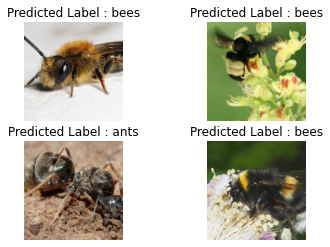

In [14]:
# visualize some prediction
import matplotlib.pyplot as plt
fig = plt.figure()
shown_batch = 0
index = 0
with torch.no_grad():
    for (images, labels) in data_loader['val']:
        if shown_batch == 1:
            break
        shown_batch += 1

        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model_conv(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(4):
            index += 1
            ax = plt.subplot(2, 2, index)
            ax.axis('off')
            ax.set_title('Predicted Label : {}'.format(class_names[predicted[i]]))
            input_img = images.cpu().data[i]
            inp = input_img.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            plt.imshow(inp)